In [1]:
import seaborn as sns
from scipy import stats
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Testing the implementation of relative PRIM using output from the CFRSS Charleston application

In [55]:
result = pd.read_csv('data/cfrss_prim_likelihood.csv')
result.head()

,SLR,EconGr,risk
0,0.116116,0.0,8.946546e+08
1,0.324324,0.0,1.040898e+09
2,0.988989,0.0,1.507753e+09
3,2.682683,0.0,3.333836e+09
4,3.071071,0.0,3.820017e+09


C:\Users\jafino\Anaconda3\envs\cocitip\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


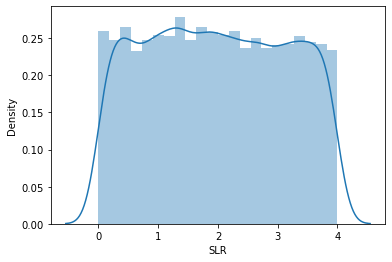

C:\Users\jafino\Anaconda3\envs\cocitip\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


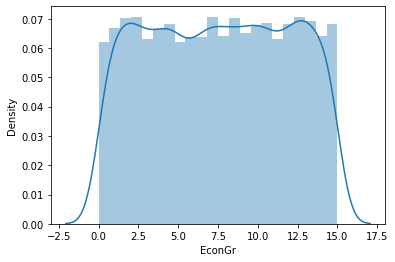

C:\Users\jafino\Anaconda3\envs\cocitip\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


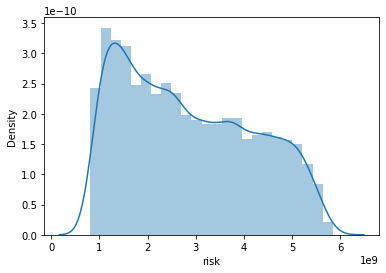

In [56]:
sns.distplot(result['SLR'])
plt.show()
sns.distplot(result['EconGr'])
plt.show()
sns.distplot(result['risk'])
plt.show()

### Generate arbitrary relative likelihood for each uncertain variable

In [57]:
mu_list = {'SLR': 2, 'EconGr': 7.5}
std_list = {'SLR': 0.5, 'EconGr': 1.5}

for var in ['SLR', 'EconGr']:
    result[var+'_likelihood'] = stats.norm.pdf(result[var], mu_list[var], std_list[var])
    result[var+'_likelihood'] /= np.max(result[var+'_likelihood'])
#     experiments[var+'_likelihood'] /= np.sum(experiments[var+'_likelihood'])
#     print(var, np.sum(experiments[var+'_likelihood']), np.max(experiments[var+'_likelihood']))

In [58]:
result

,SLR,EconGr,risk,SLR_likelihood,EconGr_likelihood
0,0.116116,0.0,8.946546e+08,0.000827,0.000004
1,0.324324,0.0,1.040898e+09,0.003640,0.000004
2,0.988989,0.0,1.507753e+09,0.129474,0.000004
3,2.682683,0.0,3.333836e+09,0.393725,0.000004
4,3.071071,0.0,3.820017e+09,0.100824,0.000004
...,...,...,...,...,...
9995,1.757758,15.0,2.600911e+09,0.889270,0.000004
9996,2.406406,15.0,3.445941e+09,0.718691,0.000004
9997,2.422422,15.0,3.468432e+09,0.699861,0.000004
9998,2.758759,15.0,3.940743e+09,0.316187,0.000004


In [59]:
result['rel_prob'] = 1
for col in result.columns:
    if 'likelihood' in col:
        result['rel_prob'] *= result[col]
        
result['rel_prob'] = result['rel_prob'] / np.mean(result['rel_prob'])
np.sum(result['rel_prob']), len(result)

(10000.0, 10000)

In [60]:
result

,SLR,EconGr,risk,SLR_likelihood,EconGr_likelihood,rel_prob
0,0.116116,0.0,8.946546e+08,0.000827,0.000004,4.061526e-08
1,0.324324,0.0,1.040898e+09,0.003640,0.000004,1.788241e-07
2,0.988989,0.0,1.507753e+09,0.129474,0.000004,6.360704e-06
3,2.682683,0.0,3.333836e+09,0.393725,0.000004,1.934268e-05
4,3.071071,0.0,3.820017e+09,0.100824,0.000004,4.953226e-06
...,...,...,...,...,...,...
9995,1.757758,15.0,2.600911e+09,0.889270,0.000004,4.368754e-05
9996,2.406406,15.0,3.445941e+09,0.718691,0.000004,3.530742e-05
9997,2.422422,15.0,3.468432e+09,0.699861,0.000004,3.438238e-05
9998,2.758759,15.0,3.940743e+09,0.316187,0.000004,1.553345e-05


### Now run both modified (dummy) PRIM and normal PRIM

In [61]:
from ema_workbench_l.analysis import relative_prim, prim
from ema_workbench_l import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

Normal PRIM

In [62]:
x = result[['SLR', 'EconGr']]
data = result['risk']
y = data > 4e9

prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] 10000 points remaining, containing 2424 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.1963, coverage: 0.8098184818481848, density: 1.0 restricted_dimensions: 2


PRIM with non-binary y

In [63]:
prim_alg = relative_prim.RelativePrim(relative_likelihood=result['rel_prob'], x=x, y=y, threshold=0.2)
box2 = prim_alg.find_box()

[MainProcess/INFO] 10000 points remaining, containing 199.08627874415822 cases of interest


199.08627874415822


[MainProcess/INFO] mean: 0.7732535332140238, mass: 0.0517, coverage: 0.9910317418645542, density: 0.7732535332140238 restricted_dimensions: 2


### Compare coverage-density threshold

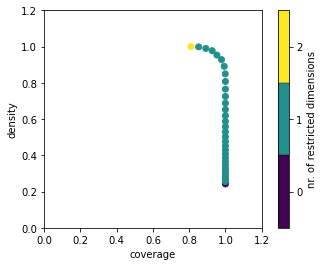

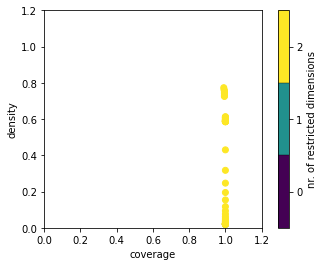

In [64]:
box1.show_tradeoff()
plt.show()
box2.show_tradeoff()
plt.show()

In [65]:
pt_1 = box1.peeling_trajectory
pt_2 = box2.peeling_trajectory
pt_1['box'] = 'box1_PRIM'
pt_2['box'] = 'box2_PRIM_likelihood'
box_combined = pt_1.append(pt_2)

(0.1, 1.02)

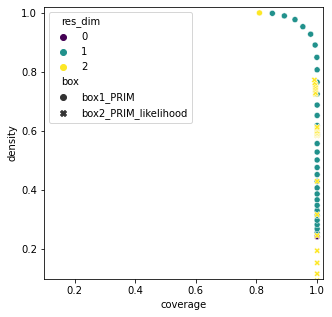

In [66]:
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(x='coverage', y='density', hue='res_dim', data=box_combined, style='box', palette='viridis', ax=ax)
ax.set_ylim(0.1,1.02)
ax.set_xlim(0.1,1.02)

### Does the standard PRIM adequately capture relative likelihood information? To investigate this, we compare weighted density and coverage from each box from the normal PRIM run

In [67]:
result['y'] = y
total_coi = result.loc[result['y'], 'rel_prob'].sum()
print(result['y'].sum())

2424


In [68]:
box2.peeling_trajectory['weighted_coverage'] = 0
box2.peeling_trajectory['weighted_density'] = 0

for i in range(len(box2.box_lims)):
    if i > -1:
        all_vars = list(box2.qp[i])
        experiments_ = result.copy()
        for var in all_vars:
            upper_lim = box2.box_lims[i][var][1]
            lower_lim = box2.box_lims[i][var][0]
            experiments_ = experiments_.loc[(experiments_[var]>lower_lim) & (experiments_[var]<upper_lim)]
            
        #calculate weighted coverage
        coi_in_box = experiments_.loc[experiments_['y'], 'rel_prob'].sum()
        #print(coi_in_box, experiments_['y'].sum(), total_coi)
        weighted_coverage = coi_in_box / total_coi
        
        #calculate weighted density
        total_cases_in_box = experiments_['rel_prob'].sum()
        weighted_density = coi_in_box / total_cases_in_box
        
        box2.peeling_trajectory.loc[i, 'weighted_coverage'] = weighted_coverage
        box2.peeling_trajectory.loc[i, 'weighted_density'] = weighted_density

In [69]:
box_to_show1 = pd.DataFrame()
box_to_show1['coverage'] = box2.peeling_trajectory['coverage']
box_to_show1['density'] = box2.peeling_trajectory['density']
box_to_show1['Weighted?'] = 'No'

box_to_show2 = pd.DataFrame()
box_to_show2['coverage'] = box2.peeling_trajectory['weighted_coverage']
box_to_show2['density'] = box2.peeling_trajectory['weighted_density']
box_to_show2['Weighted?'] = 'Yes'

box_to_show = box_to_show1.append(box_to_show2).reset_index()

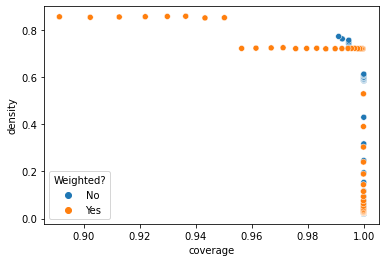

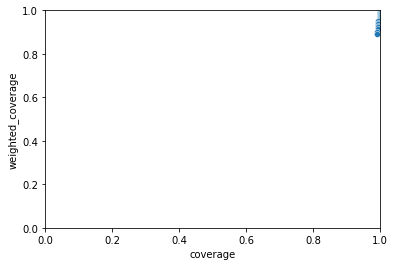

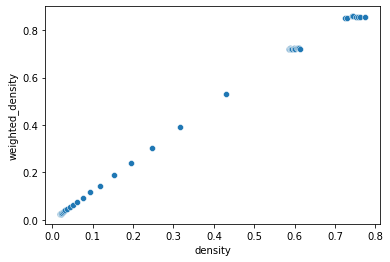

In [70]:
sns.scatterplot(x='coverage', y='density', data=box_to_show, hue='Weighted?')
plt.show()
ax = sns.scatterplot(x='coverage', y='weighted_coverage', data=box2.peeling_trajectory)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()
sns.scatterplot(x='density', y='weighted_density', data=box2.peeling_trajectory)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

### Check boxes with comparable density and coverage

In [73]:
result['y'] = y
print(result['y'].sum())

2424


In [74]:
#standard PRIM
prim_alg = prim.Prim(x, y, threshold=0.75)
normal_prim = prim_alg.find_box()

#weighted PRIM
prim_alg = relative_prim.RelativePrim(relative_likelihood=result['rel_prob'], x=x, y=y, threshold=0.2)
rel_prim = prim_alg.find_box()

[MainProcess/INFO] 10000 points remaining, containing 2424 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.1963, coverage: 0.8098184818481848, density: 1.0 restricted_dimensions: 2
[MainProcess/INFO] 10000 points remaining, containing 199.08627874415822 cases of interest


199.08627874415822


[MainProcess/INFO] mean: 0.7732535332140238, mass: 0.0517, coverage: 0.9910317418645542, density: 0.7732535332140238 restricted_dimensions: 2


In [82]:
i1 = 22
normal_prim.peeling_trajectory.iloc[i1]

coverage         1.0
density     0.765393
id                22
mass          0.3167
mean        0.765393
res_dim            1
Name: 22, dtype: object

In [83]:
i2 = 56
rel_prim.peeling_trajectory.iloc[i2]

coverage    0.991032
density     0.773254
id                56
mass          0.0517
mean        0.773254
res_dim            2
Name: 56, dtype: object

In [84]:
normal_prim.box_lims[i1]

,SLR,EconGr
0,2.692693,0.0
1,4.000000,15.0


In [85]:
rel_prim.box_lims[i2]

,SLR,EconGr
0,2.948949,4.842342
1,3.509510,10.503003


In [86]:
labels = ['Low','Medium','High','Highest']
result['likelihood_cat'] = pd.qcut(result['rel_prob'], q=[0., 0.25, 0.5, 0.75, 1.], labels=labels)

<AxesSubplot:xlabel='SLR', ylabel='EconGr'>

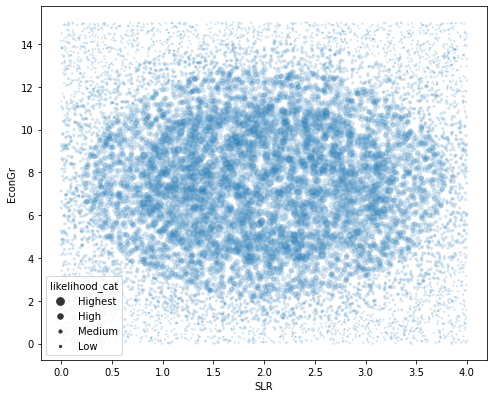

In [87]:
fig, ax = plt.subplots(figsize=(8,6.5))
sns.scatterplot(x='SLR', y='EconGr', data=result, size='likelihood_cat', alpha=0.2, ax=ax, 
                size_order = labels[::-1], sizes=[60,30,10,5])

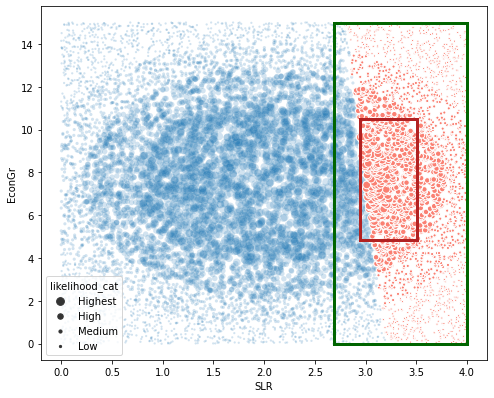

In [88]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(8,6.5))
sns.scatterplot(x='SLR', y='EconGr', data=result.loc[~result['y']], size='likelihood_cat', alpha=0.2, ax=ax, 
                size_order = labels[::-1], sizes=[60,30,10,5])
sns.scatterplot(x='SLR', y='EconGr', data=result.loc[result['y']], size='likelihood_cat', color='salmon', ax=ax, 
                size_order = labels[::-1], sizes=[60,30,10,5], legend=False, linewidth=1)

#add box
box1_lim = normal_prim.box_lims[i1]
box2_lim = rel_prim.box_lims[i2]
currentAxis = plt.gca()

currentAxis.add_patch(Rectangle((box1_lim.loc[0, 'SLR'], box1_lim.loc[0, 'EconGr']), 
                                box1_lim.loc[1, 'SLR'] - box1_lim.loc[0, 'SLR'], box1_lim.loc[1, 'EconGr'] - box1_lim.loc[0, 'EconGr'],
                                alpha=1, facecolor='none', lw=3, edgecolor='darkgreen'))

currentAxis.add_patch(Rectangle((box2_lim.loc[0, 'SLR'], box2_lim.loc[0, 'EconGr']), 
                                box2_lim.loc[1, 'SLR'] - box2_lim.loc[0, 'SLR'], box2_lim.loc[1, 'EconGr'] - box2_lim.loc[0, 'EconGr'],
                                alpha=1, facecolor='none', lw=3, edgecolor='firebrick'))